In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

from functools import partial
from typing import Callable, List
import warnings

import pandas as pd
from scipy.stats import (multivariate_normal as mnorm,
                         truncnorm as sp_truncnorm,
                         norm as sp_norm,
                         chi2)
import seaborn as sns

sns.set(style='ticks', context='talk')

from var_selection import gibbs, bayes_factor, variable_selection

def truncnorm(a, b, loc=0, scale=1):
    a, b = (a - loc)/scale, (b - loc)/scale
    return sp_truncnorm(a=a, b=b, loc=loc, scale=scale)

Populating the interactive namespace from numpy and matplotlib


## Test Gibbs Sampler

In [2]:
M = 2
mu = np.random.rand(M) * 100

while True:
    try:
        cov = np.random.rand(M, M)
        cov = (cov + cov.T)/2
        np.linalg.cholesky(cov)
        break
    except np.linalg.LinAlgError:
        pass
print(mu)
print(cov)

[ 74.89688509  95.79761833]
[[ 0.75747702  0.46909801]
 [ 0.46909801  0.85353653]]


x    74.901169
y    95.800833
dtype: float64
          x        y
x  0.755731  0.47671
y  0.476710  0.87331


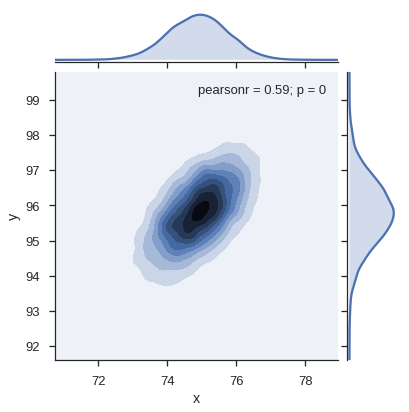

In [3]:
norm_df = pd.DataFrame(mnorm(mu, cov).rvs(10000), columns=['x', 'y'])
print(norm_df.mean())
print(norm_df.cov())
sns.jointplot(x='x', y='y', data=norm_df, kind='kde');

In [4]:
def f1(X, j, mu, cov):
    sigma_1 = cov[0, 0]**0.5
    sigma_2 = cov[1, 1]**0.5
    rho = cov[0, 1]/(sigma_1*sigma_2)
    loc = mu[0] + (sigma_1/sigma_2)*rho*(X[1] - mu[1])
    scale = (1 - rho**2)*sigma_1**2
    return sp_norm(loc=loc, scale=scale).rvs()


def f2(X, j, mu, cov):
    sigma_1 = cov[0, 0]**0.5
    sigma_2 = cov[1, 1]**0.5
    rho = cov[0, 1]/(sigma_1*sigma_2)
    loc = mu[1] + (sigma_2/sigma_1)*rho*(X[0] - mu[0])
    scale = (1 - rho**2)*sigma_2**2
    return sp_norm(loc=loc, scale=scale).rvs()


distributions = [partial(f1, mu=mu, cov=cov), partial(f2, mu=mu, cov=cov)]
iterations = 10000
samples = gibbs(np.zeros((1, 2)), iterations, distributions)
gibbs_df = pd.DataFrame(samples, columns=['x', 'y'])
print(gibbs_df.mean())
print(gibbs_df.cov())

x    74.884495
y    95.780990
dtype: float64
          x         y
x  1.259949  1.149333
y  1.149333  1.501892


1000
x    74.892092
y    95.785463
dtype: float64
          x         y
x  0.384877  0.225584
y  0.225584  0.437717


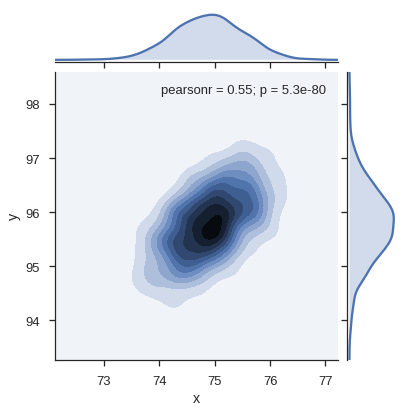

In [5]:
drop = 1000
thin = 9
thinned_df = gibbs_df.iloc[drop:iterations:thin]
print(len(thinned_df))
print(thinned_df.mean())
print(thinned_df.cov())
sns.jointplot(x='x', y='y', data=thinned_df, kind='kde');

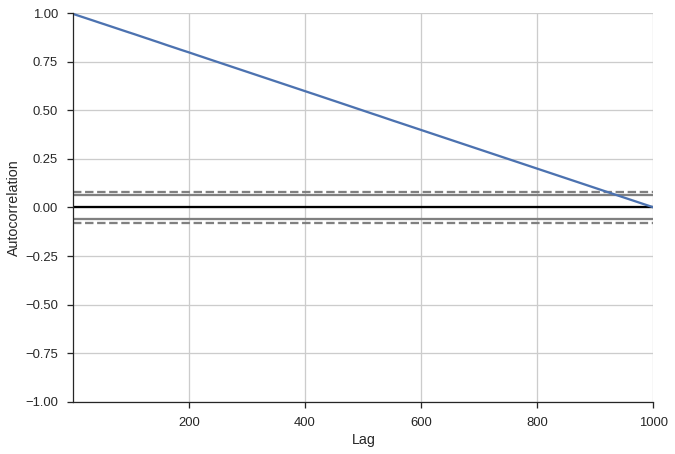

In [6]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(thinned_df)
sns.despine()

# Variable Selection

## Test

In [7]:
size = 1000
dims = 10
zero_coefs = np.random.rand(dims) < 0.5
coefs = np.random.rand(1, dims)
coefs[:, zero_coefs] = 0

X = np.random.rand(size, dims)
Y = ((X @ coefs.T) + np.random.randn(size, 1)*10)
print(Y.shape)
coefs

(1000, 1)


array([[ 0.        ,  0.16145588,  0.35831203,  0.        ,  0.        ,
         0.38911998,  0.891036  ,  0.        ,  0.        ,  0.70386456]])

In [8]:
β_zero = np.random.randn(dims)
var_zero = 15
p = np.array([0.5]*dims)
τ = np.ones_like(β_zero)
υ = -10 * np.ones_like(β_zero)
λ = 10 * np.ones_like(β_zero)
ν = 2
iterations = 1000
β, var, chain, probs = variable_selection(X, Y, β_zero, var_zero, p, τ, ν, υ, λ, iterations)

## Test 2

(100, 1)


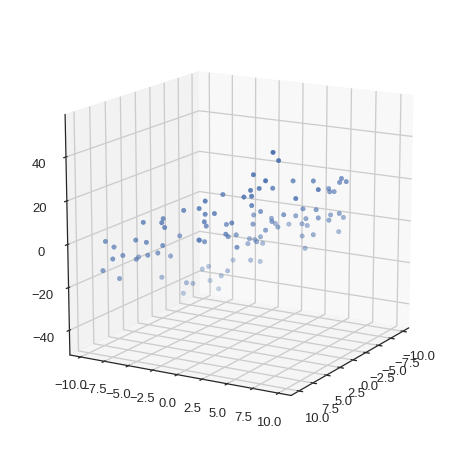

In [9]:
X = np.random.rand(100, 2) * 20 - 10
Y = X @ [[2], [3]] + np.random.randn(100, 1)*5

print(Y.shape)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X.T, Y)
ax.view_init(15, 30)

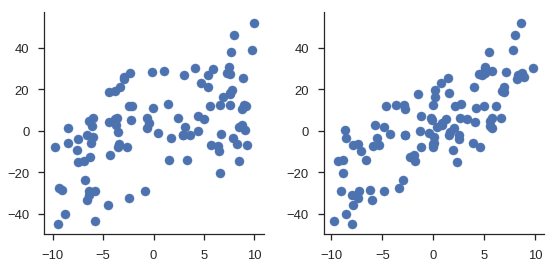

In [10]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(X[:, 0], Y)
ax2.scatter(X[:, 1], Y)
plt.tight_layout()
sns.despine()

In [13]:
β_zero = np.array([0, 0])
var_zero = 10000
p = np.array([0.5, 0.5])
τ = np.ones_like(β_zero)
υ = -10 * np.ones_like(β_zero)
λ = 10 * np.ones_like(β_zero)
ν = 2
iterations = 1000
β, var, chain, probs = variable_selection(X, Y, β_zero, var_zero, p, τ, ν, υ, λ, iterations)